# Notebook version of Main python file that will be used to create visualization tool

The final tool will likely be a more concise .py file,  but this notebook should be helpful for creating the tool and debugging

# Structure of Application

1. Initial script section that loads all the libraries we need, the pre cleaned data set (see the "Initial_Data_Cleaning_Script" file), and does some pre-processing / setting up of the interface
2. Methods:

3. Usage






## Initial Script

In [12]:
import pandas as pd
import numpy as np

# from bokeh.io import output_file
from bokeh.io import output_notebook
from bokeh.layouts import column
from bokeh.models import Button
from bokeh.palettes import RdYlBu3
from bokeh.plotting import figure, curdoc, show
output_notebook()

from random import random



Loading BokehJS ...

In [2]:
#load data

original_data=pd.read_csv("C:/Users/Caleb/Desktop/Poolla Lab/Data/15min_all_homes_data.csv")

                          

In [3]:
#get rid of second index column left over from the csv file
original_data.head(5)
working_df=original_data.drop(columns=["Unnamed: 0"])
print("size of our initial dataframe is:\n", working_df.shape)
working_df.head(5)

size of our initial dataframe is:
 (2120409, 80)


,dataid,local_15min,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,...,sumppump1,utilityroom1,venthood1,waterheater1,waterheater2,wellpump1,winecooler1,leg1v,leg2v,state
0,3687,2014-01-01 00:00:00-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.239,119.769,CA
1,3687,2014-01-01 00:15:00-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.256,119.628,CA
2,3687,2014-01-01 00:30:00-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.358,119.859,CA
3,3687,2014-01-01 00:45:00-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.766,119.985,CA
4,3687,2014-01-01 01:00:00-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.844,120.368,CA


In [4]:
#grab only the columns that we will be using for this application: timestamp, solar, car1, car2, grid

working_df=working_df.loc[:,["dataid","state","local_15min","grid","solar","car1","car2"]]

working_df

,dataid,state,local_15min,grid,solar,car1,car2
0,3687,CA,2014-01-01 00:00:00-06,1.717,NaN,NaN,NaN
1,3687,CA,2014-01-01 00:15:00-06,1.905,NaN,NaN,NaN
2,3687,CA,2014-01-01 00:30:00-06,1.923,NaN,NaN,NaN
3,3687,CA,2014-01-01 00:45:00-06,1.535,NaN,NaN,NaN
4,3687,CA,2014-01-01 01:00:00-06,1.010,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2120404,9278,TX,2018-12-31 22:45:00-06,1.481,-0.004,NaN,NaN
2120405,9278,TX,2018-12-31 23:00:00-06,1.043,-0.003,NaN,NaN
2120406,9278,TX,2018-12-31 23:15:00-06,0.740,-0.003,NaN,NaN
2120407,9278,TX,2018-12-31 23:30:00-06,0.685,-0.003,NaN,NaN


In [7]:
#now convert timestamps to correct datatype


zz=pd.to_datetime((working_df["local_15min"]+"00"),format="%Y-%m-%d %H:%M:%S%z",errors="coerce")
working_df=working_df.assign(local_15min=zz)


working_df.dtypes

dataid           int64
state           object
local_15min     object
grid           float64
solar          float64
car1           float64
car2           float64
dtype: object

In [8]:
working_df["local_15min"][0
                         ]

Timestamp('2014-01-01 00:00:00-0600', tz='pytz.FixedOffset(-360)')

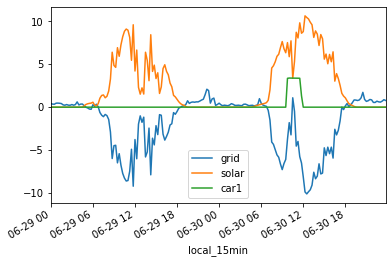

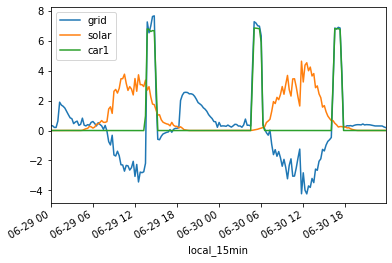

In [10]:
dataids_ex=[27,5679]
def plot_house_info(df,dataids,start_date,end_date):
  #######dataids is a list, start_date and end_date are strings (ex:'2019-06-29' or '2019-06' to just specifiy a month)

  # fig, axs=mp.subplots(1,len(dataids),figsize = (50,20))
  # fig.subplots_adjust(hspace=0.2, wspace=0.1)
  ii=0

  for home in dataids:

    home_df=df.loc[df["dataid"]==home,:].set_index("local_15min")
    home_df.loc[start_date:end_date,["grid","solar","car1"]].plot()

    ii+=1


plot_house_info(working_df,dataids_ex,"2019-06-29","2019-06-30")

In [13]:
# create a plot and style its properties
p = figure(x_range=(0, 100), y_range=(0, 100), toolbar_location=None)
p.border_fill_color = 'black'
p.background_fill_color = 'black'
p.outline_line_color = None
p.grid.grid_line_color = None

# add a text renderer to our plot (no data yet)
r = p.text(x=[], y=[], text=[], text_color=[], text_font_size="20pt",
           text_baseline="middle", text_align="center")

i = 0

ds = r.data_source

# create a callback that will add a number in a random location
def callback():
    global i

    # BEST PRACTICE --- update .data in one step with a new dict
    new_data = dict()
    new_data['x'] = ds.data['x'] + [random()*70 + 15]
    new_data['y'] = ds.data['y'] + [random()*70 + 15]
    new_data['text_color'] = ds.data['text_color'] + [RdYlBu3[i%3]]
    new_data['text'] = ds.data['text'] + [str(i)]
    ds.data = new_data

    i = i + 1

# add a button widget and configure with the call back
button = Button(label="Press Me")
button.on_click(callback)

# put the button and plot in a layout and add to the document
curdoc().add_root(column(button, p))

In [14]:
bokeh serve --show Main_visualization_tool_development.ipynb

SyntaxError: invalid syntax (<ipython-input-14-156ed116b5a8>, line 1)